We have here two goals to accomplish:
1. Investigate how more data helps performance
2. Bifurcation diagram

In [1]:
import sys
sys.path.append("./source")

import pandas as pd
import NovakTyson
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import train_onestep
import predict_onestep
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Number of time series to generate
N = 100

# cyclin synthesis and degradation are inhibited
time_points, novak_data = NovakTyson.simulate_custom(cyclin=0, MPF=0, tlast=1500, k1=0, v2_1=0, v2_2=0, cdc25_total=5)
data_numpy = np.zeros((100, novak_data.shape[1], novak_data.shape[2]))

cyclin_list = np.random.uniform(0, 32, N)
for i in range(N):
    # cyclin synthesis and degradation are inhibited
    _, data_numpy[i, :, :] = NovakTyson.simulate_custom(cyclin = cyclin_list[i], MPF=0, tlast=1500, k1=0, v2_1=0, v2_2=0, cdc25_total=5)
    
# replace all values that are numerically zero
data_numpy = np.where(data_numpy < 1e-4, 0, data_numpy)

In [3]:
# create a data frame
df = pd.DataFrame(data_numpy[0])
df.columns = ['cyclin', 'MPF', 'preMPF', 'cdc25P', 'wee1P', 'IEP', 'APC']
df['Strain'] = [0] * df.shape[0]
df['Time'] = time_points
for j in range(1, N):
    dummy = pd.DataFrame(data_numpy[j])
    dummy.columns = ['cyclin', 'MPF', 'preMPF', 'cdc25P', 'wee1P', 'IEP', 'APC']
    dummy['Strain'] = [j] * dummy.shape[0]
    dummy['Time'] = time_points
    df = pd.concat([df, dummy])

df.set_index('Strain', inplace=True)
display(df)

,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC,Time
Strain,,,,,,,,
0,23.793140,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0
0,21.553535,2.026563,0.213044,0.004165,0.002123,0.972968,0.993767,0.2
0,19.565987,3.463323,0.763832,0.014916,0.007593,0.952107,0.991510,0.4
0,17.795080,4.455125,1.542937,0.030132,0.015306,0.935978,0.990289,0.6
0,16.211588,5.114047,2.467505,0.048236,0.024438,0.923146,0.989510,0.8
...,...,...,...,...,...,...,...,...
99,0.000000,0.448058,8.578355,0.096276,0.045759,0.000629,0.000623,1499.0
99,0.000000,0.448058,8.578355,0.096276,0.045759,0.000629,0.000623,1499.2
99,0.000000,0.448058,8.578355,0.096276,0.045759,0.000629,0.000623,1499.4


In [4]:
feature_list = [] # here we do not have external time-series
target_list = ['cyclin', 'MPF', 'preMPF', 'cdc25P', 'wee1P', 'IEP', 'APC']
df.describe()

,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC,Time
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,0.028311,9.485075,8.382859,2.493099,0.453256,0.479941,0.485610,749.900000
std,0.566819,9.316318,4.619730,2.379337,0.390887,0.493176,0.489588,433.012987
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.568259,6.588604,0.122814,0.057829,0.000811,0.000807,374.950000
50%,0.000000,3.013738,6.635832,0.796317,0.268870,0.009094,0.132476,749.900000
75%,0.000000,17.976271,10.816250,4.969867,0.853144,0.992963,0.989960,1124.850000
max,31.334167,24.649574,26.851393,4.979674,0.894109,1.000000,1.000000,1499.800000


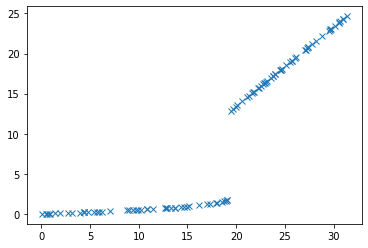

In [5]:
# plot the bifurcation diagram from data

mpf_list = [data_numpy[i][-1][1] for i in range(N)]
plt.plot(cyclin_list, mpf_list, 'x')

cyclin


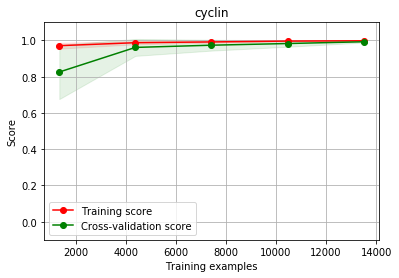

Target: cyclin, CV Pearson R2 coefficient: 0.999415
MPF


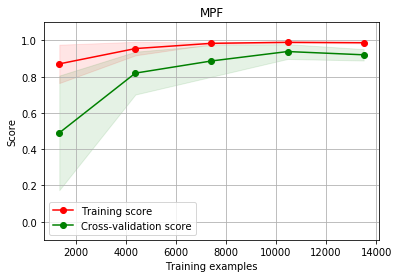

Target: MPF, CV Pearson R2 coefficient: 0.992612
preMPF


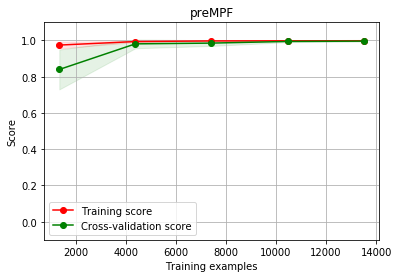

Target: preMPF, CV Pearson R2 coefficient: 0.998982
cdc25P


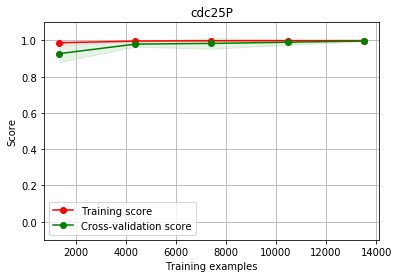

Target: cdc25P, CV Pearson R2 coefficient: 0.999576
wee1P


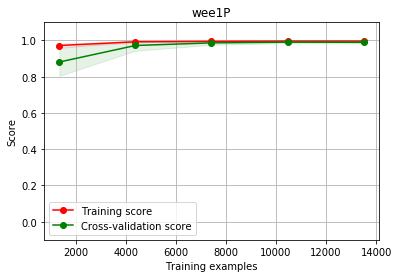

Target: wee1P, CV Pearson R2 coefficient: 0.996921
IEP


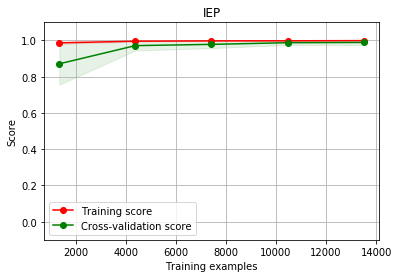

Target: IEP, CV Pearson R2 coefficient: 0.999266
APC


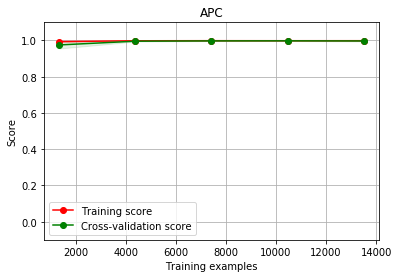

Target: APC, CV Pearson R2 coefficient: 0.999061
Average training score: 0.9979762589229951


In [ ]:
strain_list = df.index.unique().values[1:3]
data_2 = df.loc[strain_list]
df_2 = train_onestep.generate_dataset(data_2, list(strain_list),feature_list, target_list, n_dim=7500)
df_test = df.loc[0]

rf_model = RandomForestRegressor(n_estimators=20)
figure_path = './plots/'
rf_dict, score_dict = train_onestep.train_classic(df_2, rf_model, plot=True,model_type='random_forest', figure_path=figure_path)
time_points, predictions = predict_onestep.predict_integrate(df_test, data_2, rf_dict, target_list, feature_list, title='test', plot=True,model_type='random_forest', subplots=(4,3), bio=True)

In [36]:
strain_list = df.index.unique().values[1:]
data_100 = df.loc[strain_list]
df_100 = train_onestep.generate_dataset(data_100, list(strain_list),feature_list, target_list, n_dim=7500)
df_test = df.loc[0]

rf_model = RandomForestRegressor(n_estimators=20)
figure_path = './plots/'
rf_dict, score_dict = train_onestep.train_classic(df_100, rf_model, plot=False,model_type='random_forest', figure_path=figure_path)
time_points, predictions = predict_onestep.predict_integrate(df_test, data_100, rf_dict, target_list, feature_list, title='test', plot=True,model_type='random_forest', subplots=(4,3), bio=True)

./source/train_onestep.py:307: RuntimeWarning: divide by zero encountered in double_scalars
  measurement_data[('target',measurement)] = np.gradient([point/delT for point in filtered_measurement])
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1084: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1091: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n
./source/train_onestep.py:307: RuntimeWarning: invalid value encountered in double_scalars
  measurement_data[('target',measureme

KeyboardInterrupt: 

# LmmNet

In [20]:
import train_lmmNet
import predict_lmmNet
import tensorflow as tf

# select first 99 as training
train_data = tf.convert_to_tensor(data_numpy[1:,:,:], dtype=tf.float32)
test_data = tf.convert_to_tensor(data_numpy[0,:,:], dtype=tf.float32)

model = train_lmmNet.train_easy(time_points, train_data)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



NameError: name 'odeint' is not defined

In [22]:
from scipy.integrate import odeint

predicted_test = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), test_data[0,:], time_points)
error_dict = {}

In [27]:
e1 = predict_lmmNet.compute_MSE(predicted_test, test_data, 0)
e2 = predict_lmmNet.compute_MSE(predicted_test, test_data, 1)
e3 = predict_lmmNet.compute_MSE(predicted_test, test_data, 2)
e4 = predict_lmmNet.compute_MSE(predicted_test, test_data, 3)
e5 = predict_lmmNet.compute_MSE(predicted_test, test_data, 4)
e6 = predict_lmmNet.compute_MSE(predicted_test, test_data, 5)
e7 = predict_lmmNet.compute_MSE(predicted_test, test_data, 6)
mse_100 = (e1, e2, e3, e4, e5, e6, e7)

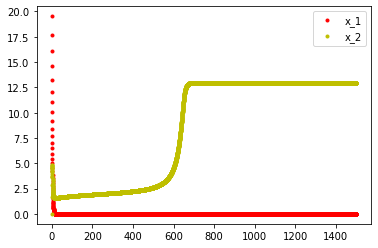

In [31]:
plt.plot(time_points, test_data[:,0], 'r.', label='x_1')
plt.plot(time_points, test_data[:,1], 'y.', label='x_2')
#plt.plot(time_points, predicted_test[:,0], 'b--', label='predicted dynamics')
#plt.plot(time_points, predicted_test[:,1], 'b--')
plt.legend()
plt.show()